# **OCR Model for Text-based CAPTCHA Recognition**
_Alfredo Villasenor-Monsivais_<br>
_Alejandra G. Silva-Trujillo_<br>
_Juan C. Cuevas-Tello_

#### **Necessary imports:**

In [1]:
import cv2
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

In [2]:
import requests
from io import BytesIO
from PIL import Image
import os
from collections import Counter

In [ ]:
from keras import layers
from keras import models
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### **Load and Pre-process the dataset:**

Download the following files in [Kaggle](https://www.kaggle.com/datasets/crawford/emnist/data):
- emnist-byclass-train.csv
- emnist-byclass-test.csv
- emnist-byclass-mapping.txt


In [ ]:
train_data = pd.read_csv("./dataset/emnist-byclass-train.csv", header = None)
test_data = pd.read_csv("./dataset/emnist-byclass-test.csv", header = None)
map_data = np.loadtxt('./dataset/emnist-byclass-mapping.txt', dtype = int, usecols = (1), unpack = True)

train_images = train_data.iloc[:,1:].values
train_labels = train_data.iloc[:,0].values

test_images = test_data.iloc[:,1:].values
test_labels = test_data.iloc[:,0].values

train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

def transformations(images):
    transformed_images = []
    for image in images:
        image = np.fliplr(image)
        image = np.rot90(image)
        transformed_images.append(image)
    return np.array(transformed_images)

train_images = transformations(train_images)
test_images = transformations(test_images)

train_images = train_images.reshape((697932, 784))
test_images = test_images.reshape((116323, 784))

#### **Model architecture:**
![Descripción de la imagen](./assets/cnn.jpg)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1), padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(62, activation = 'softmax'))

model.summary()

#### **Compile the model:**

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#### **Train and Save the model:**

In [ ]:
history = model.fit(train_images, train_labels, epochs = 20, batch_size = 128)
model.save('./model/emnist_model.h5')

#### **Evaluate the model:**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

#### **Show the model history graphs:**

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

#### **Make the test set predictions and show the confusion matrix:**

In [ ]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis = 1)
test_labels = np.argmax(test_labels, axis = 1)

class_names = [chr(c) for c in map_data]

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names, annot_kws = {"size": 7})
plt.xticks(fontsize = 10)
plt.yticks(rotation = 90, fontsize = 10)
plt.xlabel('Predicted  labels', fontsize = 12)
plt.ylabel('True labels', fontsize = 12)
plt.show()

#### **Load the model:**

In [6]:
model = load_model('./model/emnist_model.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

map_data = np.loadtxt('./dataset/emnist-byclass-mapping.txt', dtype = int, usecols = (1), unpack = True)

C:\Users\Alfredo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Alfredo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Image preprocessing:**

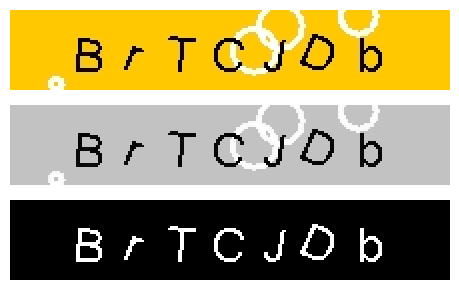

In [8]:
url = 'https://serviciosdigitales.imss.gob.mx/gestionAsegurados-web-externo/servlet/CaptchaServlet'

response = requests.get(url)

image = Image.open(BytesIO(response.content))

image_bgr = np.array(image)[:, :, ::-1]

gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

# _, thresh = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)

# inv = cv2.bitwise_not(gray)
# _, thresh = cv2.threshold(inv, 225, 255, cv2.THRESH_BINARY)

_, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(5, 3))

plt.subplot(311)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(312)
plt.imshow(gray, cmap='gray')
plt.axis('off')

plt.subplot(313)
plt.imshow(thresh, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

#### **Image segmentation:**

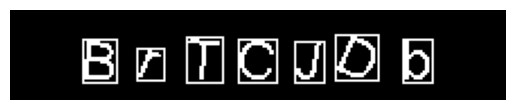

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilated = cv2.dilate(thresh, kernel, iterations=1)

contours = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[1] if imutils.is_cv3() else contours[0]

letter_image_regions = []

for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)

    letter_image_regions.append((x, y, w, h))

letter_image_regions = sorted(letter_image_regions, key = lambda x: x[0])

output_img = cv2.merge([thresh])

for (x, y, w, h) in letter_image_regions:
    cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 1)

plt.imshow(output_img, cmap='gray')
plt.axis('off')
plt.show()

#### **Make the characters' predictions:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


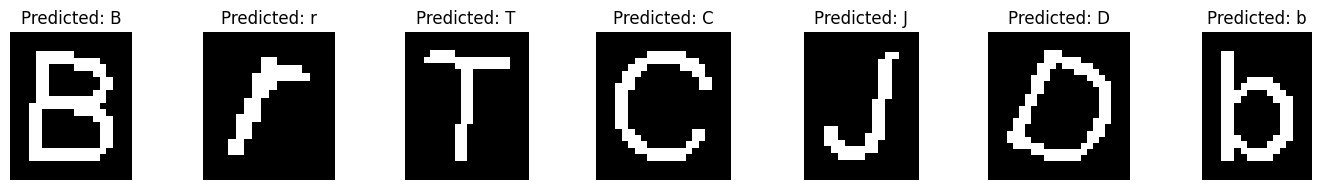

BrTCJDb


In [10]:
characters = []
predicted_labels = []
predicted_string = ""

for region in letter_image_regions:
    x, y, w, h = region

    character = thresh[y - 2:y + h + 2, x - 2:x + w + 2]

    character = cv2.resize(character, (28, 28))

    character = character.astype('float32') / 255.0

    character = character.reshape((1, 784))
    
    characters.append(character)

characters = np.concatenate(characters, axis = 0)

predictions = model.predict(characters)

predicted_labels = np.argmax(predictions, axis = 1)
probabilities = np.max(predictions, axis = 1)

plt.figure(figsize = (len(predicted_labels) * 2, 2))

for i, (region, predicted_label, prob) in enumerate(zip(letter_image_regions, predicted_labels, probabilities), 1):
    x, y, w, h = region

    character = thresh[y - 2:y + h + 2, x - 2:x + w + 2]

    predicted_string += chr(map_data[predicted_label])

    plt.subplot(1, len(predicted_labels), i)
    plt.imshow(character, cmap = 'gray')
    plt.title(f'Predicted: {predicted_string[i - 1]}')
    # plt.title(f'Predicted: {chr(map_data[predicted_label])}\nProb: {prob:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

print(predicted_string)

#### **Experimentation:**

In [4]:
def predict_CAPTCHA(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(thresh, kernel, iterations=1)

    contours = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[1] if imutils.is_cv3() else contours[0]

    letter_image_regions = []

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        letter_image_regions.append((x, y, w, h))

    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    characters = []

    for region in letter_image_regions:
        x, y, w, h = region

        character = thresh[y - 2:y + h + 2, x - 2:x + w + 2]

        character = cv2.resize(character, (28, 28))

        character = character.astype('float32') / 255.0

        character = character.reshape((1, 784))
        
        characters.append(character)

    characters = np.concatenate(characters, axis=0)

    predictions = model.predict(characters)

    predicted_labels = np.argmax(predictions, axis=1)
    percentages = np.max(predictions, axis=1)

    percentages = percentages.tolist()

    predicted_string = ""
    for predicted_label in predicted_labels:
        predicted_string += chr(map_data[predicted_label])

    return predicted_string, percentages

url = 'https://serviciosdigitales.imss.gob.mx/gestionAsegurados-web-externo/servlet/CaptchaServlet'

N = 100
samples = np.zeros((N, 9), dtype=object)

for i in range(N):
    response = requests.get(url)

    image = Image.open(BytesIO(response.content))

    image_bgr = np.array(image)[:, :, ::-1]

    prediction, percentages = predict_CAPTCHA(image_bgr)

    samples[i, 0] = i
    samples[i, 1] = prediction
    samples[i, 2:] = percentages[:7]

    filename = f"{i}-{prediction}.jpeg"
    output_path = os.path.join("./samples", filename)

    image.save(output_path, format='JPEG')

df = pd.DataFrame(samples, columns=['True', 'Prediction', '%Char1', '%Char2', '%Char3', '%Char4', '%Char5', '%Char6', '%Char7'])
df.to_csv('samples.csv', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

In [8]:
df = pd.read_csv('./samples.csv')

image_files = os.listdir('./samples')
image_files.sort()

for image in image_files:
    if image.endswith('.jpeg'):
        index, label = image.split('-')
        label = label.replace('.jpeg', '')
        
        df.loc[df['True'] == int(index), 'True'] = label

df.to_csv('samples.csv', index=False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11808\3683809457.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'H7DWu6j' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['True'] == int(index), 'True'] = label


In [9]:
df = pd.read_csv('./samples.csv')

true_column = df['True'].tolist()
all_chars_true = ''.join(true_column)
true_char_count = Counter(all_chars_true)
predicted_char_count = Counter()

classes = set("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789")
percent_columns = ['%Char1', '%Char2', '%Char3', '%Char4', '%Char5', '%Char6', '%Char7']

for _, row in df.iterrows():
    true_string = row['True']
    prediction_string = row['Prediction']
    
    for i, (true_char, pred_char) in enumerate(zip(true_string, prediction_string)):
        if true_char == pred_char:
            percent_value = row[percent_columns[i]]
            if percent_value >= 0.75:
                predicted_char_count[true_char] += 1

output_df = pd.DataFrame({
    'Character': sorted(classes),
    'Frequency': [true_char_count.get(char, 0) for char in sorted(classes)],
    'Correct Predictions': [predicted_char_count.get(char, 0) for char in sorted(classes)]
})

output_df['Accuracy'] = output_df.apply(
    lambda row: f"{(row['Correct Predictions'] / row['Frequency'] * 100):.2f}%"
    if row['Frequency'] > 0 else '0.00%',
    axis=1
)

print(output_df.to_string(index=False))

Character  Frequency  Correct Predictions Accuracy
        0          0                    0    0.00%
        1          0                    0    0.00%
        2         10                   10  100.00%
        3         12                   12  100.00%
        4          7                    7  100.00%
        5         14                   14  100.00%
        6         12                    3   25.00%
        7         17                   17  100.00%
        8         16                   16  100.00%
        9          8                    6   75.00%
        A          7                    7  100.00%
        B         21                   21  100.00%
        C         16                   16  100.00%
        D          8                    7   87.50%
        E         14                   14  100.00%
        F          8                    8  100.00%
        G         13                   12   92.31%
        H          4                    4  100.00%
        I          0           